Imports

In [1]:
# General

from scipy import stats
import scipy
from skimage.filters import threshold_otsu, rank
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from skimage.morphology import binary_erosion, binary_dilation, disk, square
import pandas as pd
import sys
from scipy import ndimage
from datacube import helpers
from datacube.utils import geometry
from matplotlib.patches import Rectangle

# PCA

# import sklearn
sys.path.append('/g/data/u46/users/sc0554/cult_area/LCCS/')
from xarray_pca import xarray_pca

# Image Seg

from skimage import io
from skimage.segmentation import quickshift
import sklearn.feature_extraction.image
import sklearn.cluster
from skimage.segmentation import mark_boundaries, slic, watershed
from skimage.util import img_as_float
from skimage.color import rgb2gray
from sklearn.impute import SimpleImputer
from skimage.filters import sobel

In [2]:
import datacube
dc=datacube.Datacube(config='/home/547/sc0554/datacube.conf', env='lccs_dev')

In [143]:
# product = 'ls8_nbart_tmad_annual'


# # Ayr
# x = (1500000, 1600000)
# y = (-2200000, -2100000)

# # Diamentina
# x = (800000, 900000)
# y = (-2800000, -2700000)

# # Gwydir
# x = (1600000, 1700000)
# y = (-3400000, -3300000)

# # Leichhardt
x = (800000, 900000)
y = (-2000000, -1900000)

# # Kakadu
# x = (0, 100000)
# y = (-1350000, -1250000)

# # Hobart
# x = (1200000, 1300000)
# y = (-4800000, -4700000)

# # Perth
# x = (-1550000, -1450000)
# y = (-3650000, -3550000)

# # Murray Valley
# x = (1100000, 1200000)
# y = (-4000000, -3900000)

# Adelaide
# x = (550000, 650000)
# y = (-3850000, -3750000)

# # Lake Eyre
# x = (500000, 600000)
# y = (-3000000, -2900000)

# # Blue mountains
# x = (1600000, 1700000)
# y = (-3900000, -3800000)

# # Australian Alps
# x = (1400000, 1500000)
# y = (-4100000, -4000000)

# # Collier Range
# x = (-1300000, -1200000)
# y = (-2700000, -2600000)

# # Coorong
# x = (600000, 700000)
# y = (-3950000, -3850000)

# # Brisbane
# x = (2000000, 2100000)
# y = (-3200000, -3100000)

# # Dundas
# x = (-1000000, -900000)
# y = (-3650000, -3550000)

query = {'time': ('2015-01-01', '2015-12-31')}
query['x'] = (x[0], x[1])
query['y'] = (y[0], y[1])
query['crs'] = 'EPSG:3577'

# K Means Clustering

In [144]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [145]:
# Load data
tmad = dc.load(product='ls8_nbart_tmad_annual', **query)

Text(0.5, 1.0, 'bcdev')

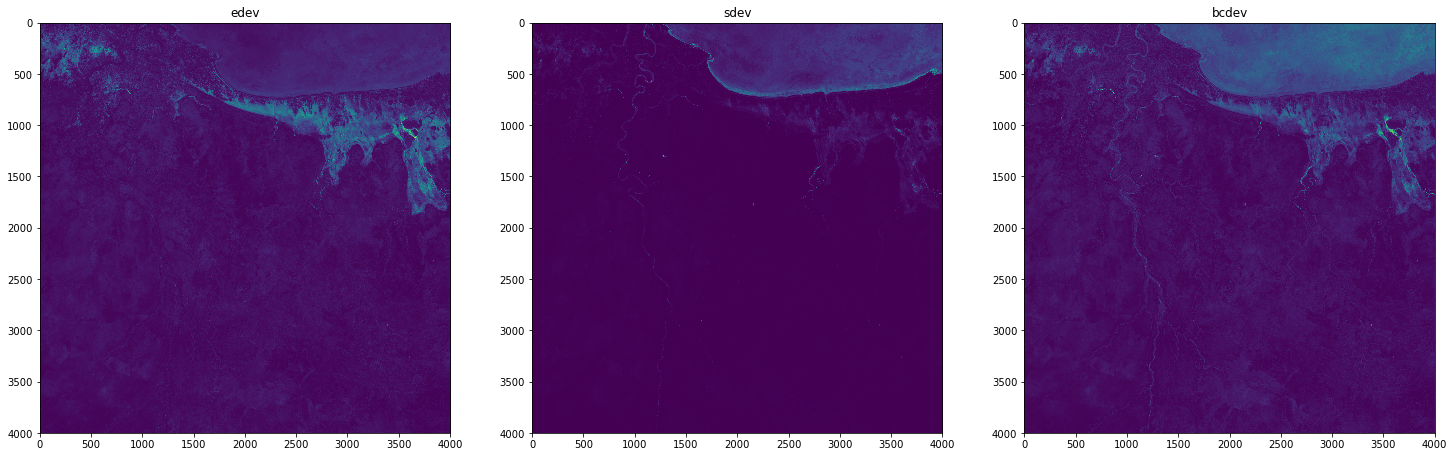

In [146]:
fig, ax = plt.subplots(1,3, figsize=(25,10))
ax[0].imshow(tmad.edev.isel(time=0))
ax[0].set_title('edev')
ax[1].imshow(tmad.sdev.isel(time=0))
ax[1].set_title('sdev')
ax[2].imshow(tmad.bcdev.isel(time=0))
ax[2].set_title('bcdev')

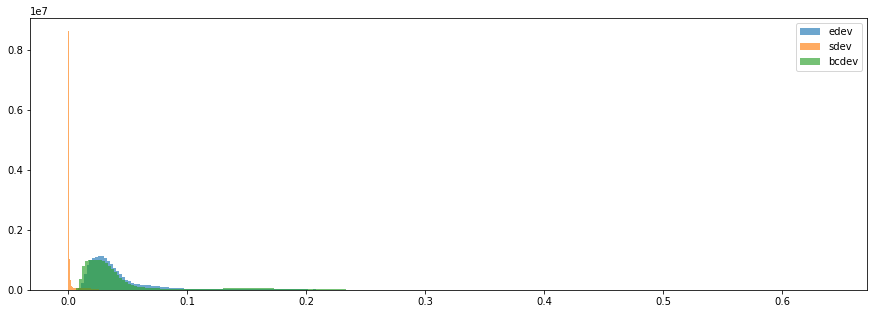

In [147]:
fig, ax = plt.subplots(ncols=1, figsize=(15,5))
ax.hist(tmad['edev'].data.ravel(), bins=256, label='edev', alpha=0.65)
ax.hist(tmad['sdev'].data.ravel(), bins=256, label='sdev', alpha=0.65)
ax.hist(tmad['bcdev'].data.ravel(), bins=256, label='bcdev', alpha=0.65)

ax.legend(prop={'size': 10})

In [148]:
# Extract data from xarray, impute NaNs and apply log transform

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

container = {}
for key in tmad.data_vars:
    d = tmad[key].data.squeeze()
    imp.fit(d)
    d = imp.transform(d)
    d = -np.log(d)
    d = np.nan_to_num(d)
#     d = np.where(x != np.nan, x, -999)
    container.update({key:d})

Text(0.5, 1.0, 'bcdev')

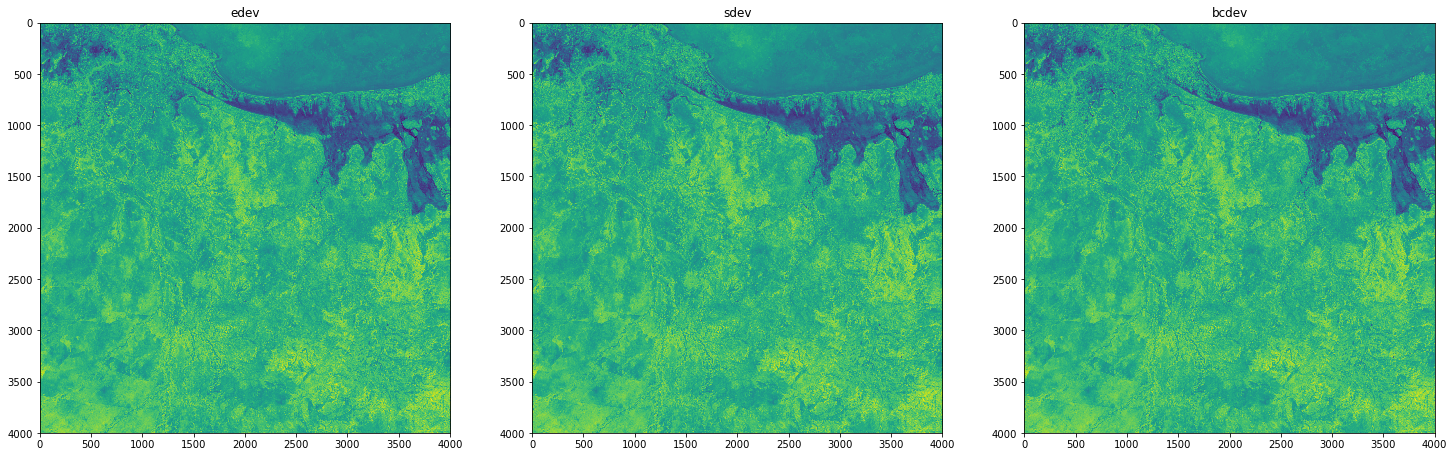

In [149]:
fig, ax = plt.subplots(1,3, figsize=(25,10))
ax[0].imshow(container['edev'])
ax[0].set_title('edev')
ax[1].imshow(container['edev'])
ax[1].set_title('sdev')
ax[2].imshow(container['edev'])
ax[2].set_title('bcdev')

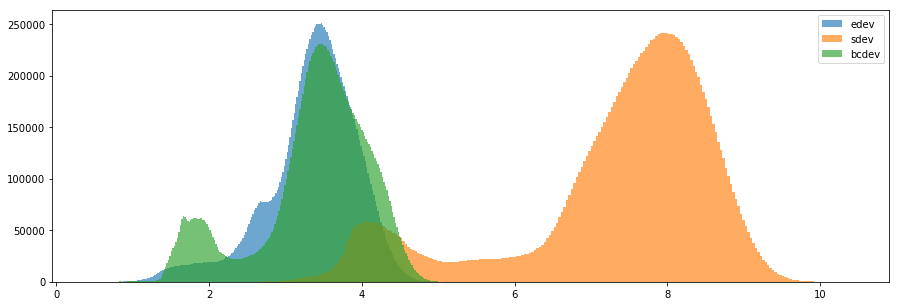

In [150]:
fig, ax = plt.subplots(ncols=1, figsize=(15,5))
ax.hist(container['edev'].ravel(), bins=256, label='edev', alpha=0.65)
ax.hist(container['sdev'].ravel(), bins=256, label='sdev', alpha=0.65)
ax.hist(container['bcdev'].ravel(), bins=256, label='bcdev', alpha=0.65)

ax.legend(prop={'size': 10})

In [151]:
fc = dc.load(product = 'fc_percentile_albers_annual', **query)

In [152]:
fc_v = fc['PV_PC_90'].values.squeeze().astype(float) # Fractional cover

In [153]:
imp.fit(fc_v)
fc_v = imp.transform(fc_v)

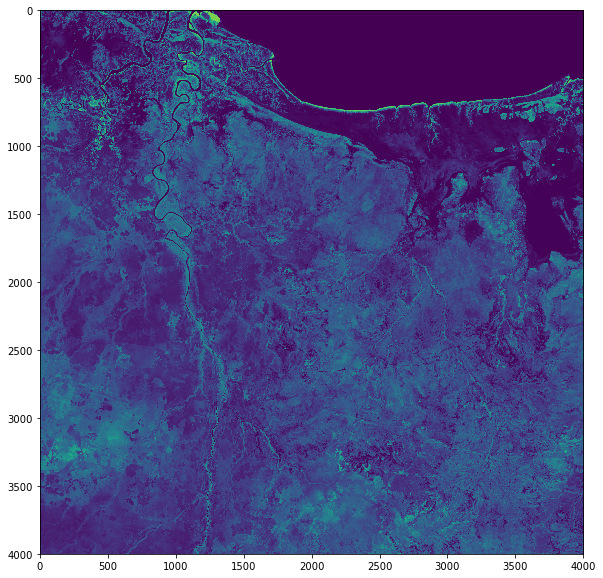

In [154]:
fig, ax = plt.subplots(1,1, figsize=(25,10))
ax.imshow(fc_v)

(array([2.436203e+06, 5.779420e+05, 2.770550e+05, 5.600510e+05,
        6.435170e+05, 1.067630e+06, 7.373170e+05, 1.114910e+06,
        7.537690e+05, 1.156817e+06, 7.698600e+05, 1.125373e+06,
        1.034370e+06, 6.168250e+05, 7.912650e+05, 4.341340e+05,
        5.129030e+05, 2.680330e+05, 3.153040e+05, 1.593680e+05,
        1.800590e+05, 9.219300e+04, 1.045050e+05, 5.205600e+04,
        5.800600e+04, 4.278400e+04, 2.163400e+04, 2.435700e+04,
        1.182800e+04, 1.316500e+04, 6.869000e+03, 8.199000e+03,
        4.748000e+03, 6.016000e+03, 3.833000e+03, 5.066000e+03,
        2.749000e+03, 3.192000e+03, 1.801000e+03, 7.590000e+02,
        3.525000e+03, 1.000000e+00, 0.000000e+00, 2.000000e+00,
        4.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 2.000000e+00]),
 array([ -1.  ,   1.54,   4.08,   6.62,   9.16,  11.7 ,  14.24,  16.78,
         19.32,  21.86,  24.4 ,  26.94,  29.48,  32.02,  34.56,  37.1 ,
         39.64,  42.18,  44.72,  47.26,  49.8 ,  5

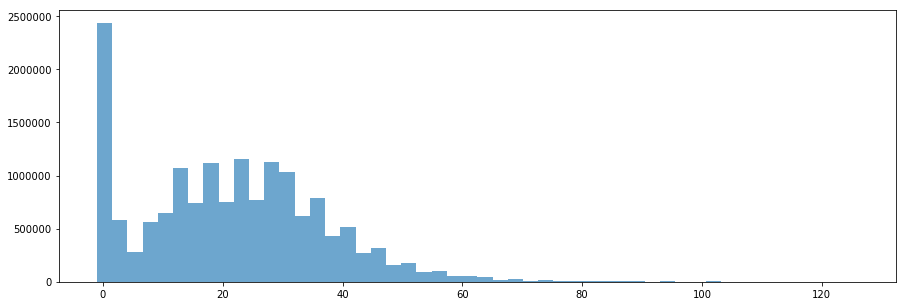

In [155]:
fig, ax = plt.subplots(ncols=1, figsize=(15,5))
ax.hist(fc_v.ravel(), bins=50, label='edev', alpha=0.65)

In [156]:
arr_con = np.stack((fc_v, container['edev'], container['sdev'], container['bcdev']), axis=-1)

In [157]:
kmeans = MiniBatchKMeans(n_clusters = 6)
new_shape = (arr_con.shape[0] * arr_con.shape[1], arr_con.shape[2])
arr_con_rs = arr_con.reshape(new_shape)
kmeans.fit(arr_con_rs)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=6,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [158]:
arr_con_kmc = kmeans.labels_
arr_con_kmc = arr_con_kmc.reshape(arr_con[:,:,0].shape)

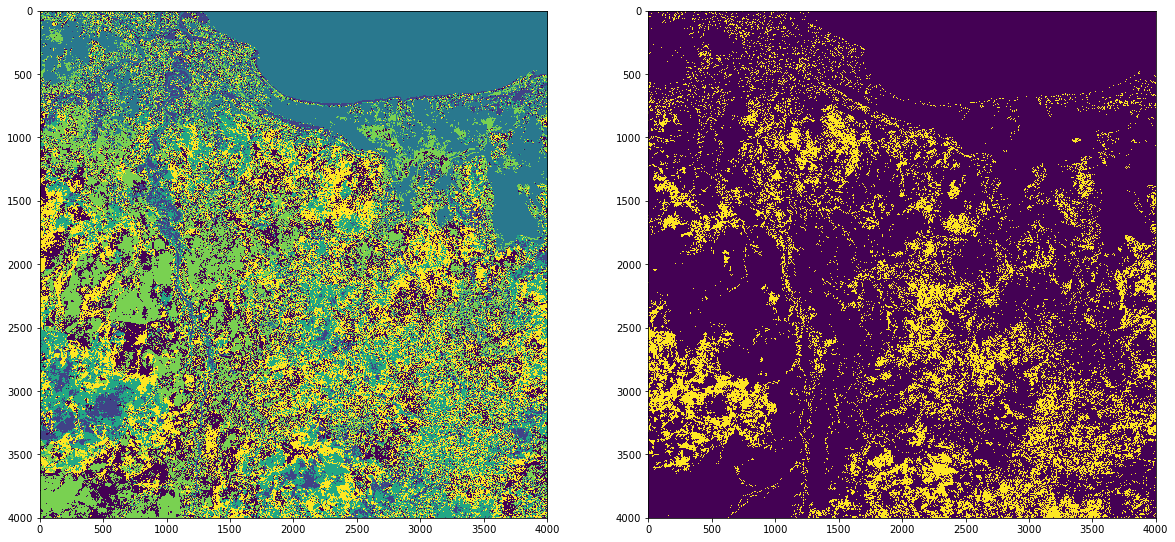

In [163]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].imshow(arr_con_kmc)
ax[1].imshow(np.where(arr_con_kmc ==3, 1, 0))

In [164]:
cult_area = np.where(arr_con_kmc == 3, 1, 0)

In [ ]:
# plt.scatter(fc_v[:, 0], fc_v[:, 1], c=y_kmeans, s=50, cmap='viridis')

# centers = fc_kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## Morphology

In [165]:
cult_area_filt = ndimage.median_filter(cult_area, 4)
# cult_area_filt = np.where(cult_area_filt == True, 1, 0).astype(float)
ero_cult = binary_erosion(cult_area, square(2))
dil_cult = binary_dilation(ero_cult, square(2))

In [166]:
dil_cult = np.where(dil_cult == True, 1, 0).astype(float)

# Plot processing stages

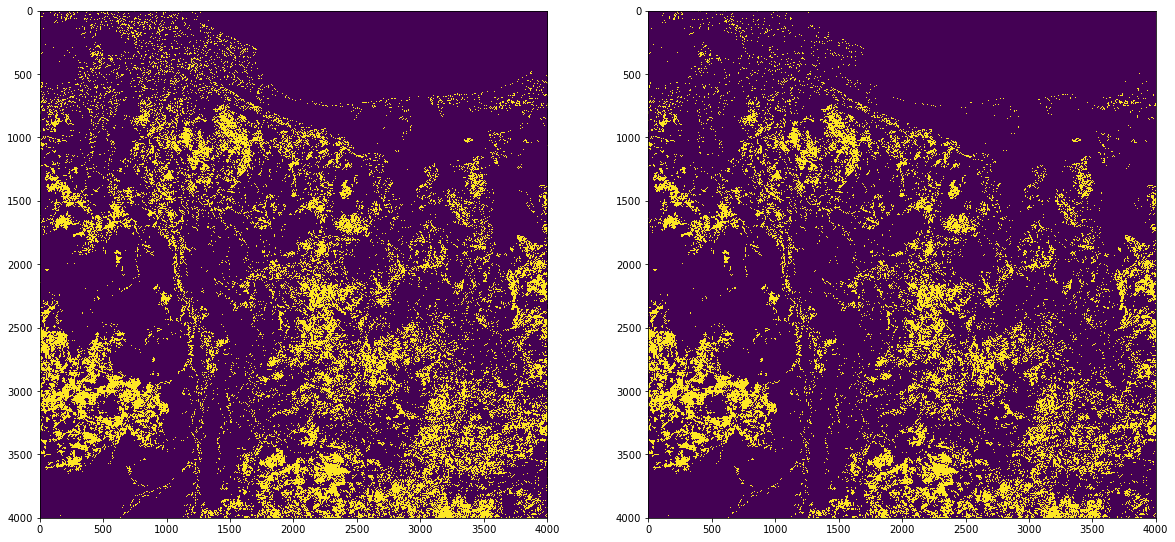

In [168]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].imshow(cult_area)
ax[1].imshow(dil_cult)

# Convert back to xarray

In [169]:
meta_d = tmad.squeeze().drop('time')

In [170]:
out = xr.Dataset({'cultfrac':(meta_d.dims,dil_cult)}, coords=meta_d.coords, attrs=meta_d.attrs)
# out.attrs = meta_d.attrs
# out.attrs['crs']=geometry.CRS(meta_d.crs.attrs['crs_wkt'])

In [171]:
helpers.write_geotiff('leichardtkm.tif', out)

In [ ]:
out.to_netcdf('caf_pca_snowy2.nc')